In [40]:
import h5py
import numpy as np
import PIL
import PIL.Image as pil
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm


from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from Pathology import *
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

gray_white_list = [0, 2, 4, 5, 6, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29]
white_gray_list = [1, 3, 7, 8, 11, 15, 25]
empty = [8]
corrupted = [15]

In [41]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger, EarlyStopping
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose

from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Activation
# from tensorflow.keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Lambda, ELU, LeakyReLU, GaussianDropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers.noise import GaussianDropout
from tensorflow.keras.models import Model

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam

from datetime import datetime
from tensorflow.keras.metrics import MeanIoU
import cv2
import os
from matplotlib import pyplot as plt
from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger, EarlyStopping
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose

from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Activation
# from tensorflow.keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Lambda, ELU, LeakyReLU, GaussianDropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers.noise import GaussianDropout
from tensorflow.keras.models import Model

from datetime import datetime
from tensorflow.keras.metrics import MeanIoU
import cv2
import os
from matplotlib import pyplot as plt
from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K


from PIL import Image
from Model import UNet1, UNet2, UNet3, UNetPlus1, UNetPlusPlus1, UNetTest, Attention_ResUNet
from Util import getDatarange, prepareData, showResults, getDatarange_multiclass, multi_class_preparation


In [43]:
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch

In [44]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

False

In [45]:
def getDatarange(hdf5File,startpat,endpat,aug=False, rows=128, cols=128):
    X = []
    Y = []
    patient_folders = list(hdf5File.keys())
    for pat in tqdm(range(startpat,endpat)):
        if pat == 15 or pat == 8:
            continue
        patient = patient_folders[pat]
        print(str(patient))
        
        Lung = hdf5File.get(str(patient) + '/LUNG')
        Mask = hdf5File.get(str(patient) + '/MASK')
        Lung_items = list(Lung.items())
        Mask_items = list(Mask.items())
        for i in tqdm(range(len(Mask_items)),desc='images'):
            Lung_img_name = Lung_items[i][1]
            Mask_img_name = Mask_items[i][1]
            Lung_imgs = np.array(Lung_img_name)
            Mask_imgs = np.array(Mask_img_name)

            if pat in white_gray_list:
                left_idxs = np.where(Mask_imgs==200)
                right_idxs = np.where(Mask_imgs==100)
                Mask_imgs[left_idxs] = 100
                Mask_imgs[right_idxs] = 200

            if Lung_imgs.shape != (rows,cols):
                Lung_ima = cv2.resize(Lung_imgs,(rows,cols))
            if Mask_imgs.shape != (rows,cols):
                Mask_ima = cv2.resize(Mask_imgs,(rows,cols))
            ret,thresh=cv2.threshold(Mask_ima,2,255,cv2.THRESH_BINARY)
            X.append(Lung_ima)
            Y.append(thresh)
    return np.array(X), np.array(Y)

In [46]:
def getDatarange_multiclass(hdf5File,startpat,endpat,aug=True, rows=128, cols=128):
	X = []
	Y = []
	patient_folders = list(hdf5File.keys())
	for pat in tqdm(range(startpat,endpat)):
		patient = patient_folders[pat]
		print(str(patient))
		
		Lung = hdf5File.get(str(patient) + '/LUNG')
		Mask = hdf5File.get(str(patient) + '/MASK')
		Lung_items = list(Lung.items())
		Mask_items = list(Mask.items())
		for i in tqdm(range(len(Mask_items)),desc='images'):
			Lung_img_name = Lung_items[i][1]
			Mask_img_name = Mask_items[i][1]
			Lung_imgs = np.array(Lung_img_name)
			Mask_imgs = np.array(Mask_img_name)

			if pat in white_gray_list:
				left_idxs = np.where(Mask_imgs==200)
				right_idxs = np.where(Mask_imgs==100)
				Mask_imgs[left_idxs] = 100
				Mask_imgs[right_idxs] = 200
				
			if Lung_imgs.shape != (rows,cols):
				Lung_ima = cv2.resize(Lung_imgs,(rows,cols))
			if Mask_imgs.shape != (rows,cols):
				Mask_ima = cv2.resize(Mask_imgs,(rows,cols))
			ret,thresh=cv2.threshold(Mask_ima,2,255,cv2.THRESH_BINARY)
			X.append(Lung_ima)
			Y.append(Mask_ima)

	return np.array(X), np.array(Y)

In [47]:
def getPolygonDatarange(hdf5File,startpat,endpat,aug=False, rows=128, cols=128):
    X = []
    Y = []
    patient_folders = list(hdf5File.keys())
    for pat in tqdm(range(startpat,endpat)):
        if pat == 15 or pat == 8:
            continue
        patient = patient_folders[pat]
        print(str(patient))

        Lung = hdf5File.get(str(patient) + '/LUNG')
        Mask = hdf5File.get(str(patient) + '/MASK')
        Lung_items = list(Lung.items())
        Mask_items = list(Mask.items())
        for i in tqdm(range(len(Mask_items)),desc='images'):
            Lung_img_name = Lung_items[i][1]
            Mask_img_name = Mask_items[i][1]
            Lung_imgs = np.array(Lung_img_name)
            Mask_imgs = np.array(Mask_img_name)

            if pat in white_gray_list:
                left_idxs = np.where(Mask_imgs==200)
                right_idxs = np.where(Mask_imgs==100)
                Mask_imgs[left_idxs] = 100
                Mask_imgs[right_idxs] = 200

            if Lung_imgs.shape != (rows,cols):
                Lung_ima = cv2.resize(Lung_imgs,(rows,cols))
            if Mask_imgs.shape != (rows,cols):
                Mask_ima = cv2.resize(Mask_imgs,(rows,cols))
            ret,thresh=cv2.threshold(Mask_ima,2,255,cv2.THRESH_BINARY)
            
            
            if aug==True:
                proba = random.uniform(0, 1)
                items = [(70,150),(100,200),(150,230),(200,240)]
                patients = random.choice(items)
                plt.imshow(Mask_ima, cmap='gray')
                ret,thresh = cv2.threshold(Mask_ima,2,255,cv2.THRESH_BINARY)
                if (proba > 0.5):
                    # replace the image with the Fake Generated Polygon
                    radius = random.randrange(5,15)
                    vertices = random.randrange(30,60)
                    contours, _= cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                    print(len(contours))
                    if(len(contours) > 0):
                        l = int(contours[0].size / 2)
                        if l > 0:
                            idx = random.randrange(0,l)
                            center = tuple(tuple(contours[0][idx])[0])
                        else:
                            center = (60,60)
                    else:
                        center = (60,60)
                    for i in range(2) :
                        Fake_Lung_imgs = createPolygonFakeImage(Lung_ima, thresh,patients[0],patients[1], 
                                        img_rows=rows, img_cols=cols, avg_radius = radius, num_vertices = vertices, center = center)
                        if i > 1:
                            sig = (i -1)*0.5
                            img = cv2.GaussianBlur(Fake_Lung_imgs,(5,5),sig)
                            Fake_Lung_imgs = img
                        X.append(Fake_Lung_imgs)
                        Y.append(thresh)
                else:
                    # keep the same image                   
                    X.append(Lung_ima)
                    Y.append(thresh)
                    print(Y.size)
            else:
                X.append(Lung_ima)
                Y.append(thresh)
    return np.array(X), np.array(Y)

In [48]:
hdf5File = h5py.File('C:\\Users\\Mdsp\\Desktop\\Catalin project\\hdf5_data_2.h5', 'r')

In [49]:
X, Y = getDatarange(hdf5File,0,30)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

BANNOURI



  3%|██▊                                                                                | 1/30 [00:00<00:27,  1.06it/s]

BENZID



  7%|█████▌                                                                             | 2/30 [00:06<01:36,  3.46s/it]

Benayoun



 10%|████████▎                                                                          | 3/30 [00:06<00:56,  2.10s/it]

Bouillon



 13%|███████████                                                                        | 4/30 [00:07<00:44,  1.70s/it]

Bousahba



 17%|█████████████▊                                                                     | 5/30 [00:08<00:30,  1.22s/it]

Bruneau



 20%|████████████████▌                                                                  | 6/30 [00:08<00:21,  1.10it/s]

CASSISA



 23%|███████████████████▎                                                               | 7/30 [00:08<00:18,  1.27it/s]

CHAUVEAU



 27%|██████████████████████▏                                                            | 8/30 [00:10<00:25,  1.14s/it]

Catillon



 33%|███████████████████████████▎                                                      | 10/30 [00:12<00:20,  1.04s/it]

Caussanel



 37%|██████████████████████████████                                                    | 11/30 [00:13<00:20,  1.06s/it]

Chevalier



 40%|████████████████████████████████▊                                                 | 12/30 [00:14<00:17,  1.01it/s]

Cohen



 43%|███████████████████████████████████▌                                              | 13/30 [00:15<00:18,  1.07s/it]

DIABY



 47%|██████████████████████████████████████▎                                           | 14/30 [00:17<00:19,  1.19s/it]

DIR



 50%|█████████████████████████████████████████                                         | 15/30 [00:19<00:19,  1.32s/it]

Debril



 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:20<00:12,  1.05it/s]

Desfrieches



 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:21<00:12,  1.04s/it]

Dioubate



 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:21<00:09,  1.14it/s]

Dourhbache



 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:23<00:10,  1.05s/it]

Erdogan



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:23<00:08,  1.09it/s]

FADLOUN



 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:24<00:06,  1.29it/s]

Farchaud



 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:25<00:06,  1.08it/s]

GARCIA



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:26<00:05,  1.00it/s]

GIRAUDEAU



 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:27<00:05,  1.04s/it]

GULLI



 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:30<00:05,  1.44s/it]

Gaiji



 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:31<00:04,  1.37s/it]

Gallier



 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:31<00:02,  1.07s/it]

Gerbaux



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:32<00:00,  1.17it/s]

Ghiles



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:32<00:00,  1.09s/it]


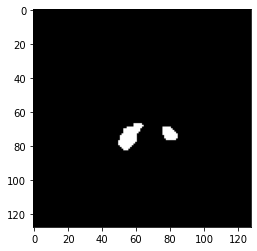

In [50]:
from matplotlib import pyplot as plt
plt.imshow(Y[40], cmap='gray')
plt.show()

In [52]:
Lung_ima = X[100]
thresh = Y[100]

In [53]:
binary_map = (thresh > 0).astype(np.uint8)
connectivity = 8 # or whatever you prefer
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)

In [54]:
contours, _= cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [55]:
idx = random.randrange(0,contours[0].size / 2 - 1)
Fake_Lung_imgs = createPolygonFakeImage(Lung_ima, thresh,200,240, img_rows=128, img_cols=128, center = tuple(tuple(contours[0][idx])[0]), avg_radius = 7, num_vertices = 100)
sig = 0.5
img = cv2.GaussianBlur(Fake_Lung_imgs,(5,5),sig)
Fake_Lung_imgs = img

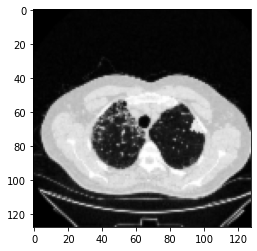

In [56]:
plt.imshow(Fake_Lung_imgs, cmap='gray')
plt.show()

In [57]:
img_size = 128
a_degrees = 12
a_distortion_scale = 0.2
a_scale = (0.8, 1.2)
a_translate = (0.133, 0.133)
a_jitter = [0.3, 0.3, 0.3, 0.3]
a_padding_ratio = 0.067

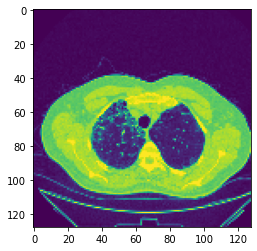

In [58]:
plt.imshow(Lung_ima)

In [59]:
def show_classic_aug(image):
    img_aug, names = [], []
    image = transforms.ToPILImage()(image)
    img_aug.append(image)
    names.append("Original-Image")
    img_aug.append(transforms.RandomRotation(degrees=(-a_degrees, a_degrees))(image))
    names.append("RandomRotation")
    img_aug.append(transforms.RandomHorizontalFlip(p=1)(image))
    names.append("RandomHorizontalFlip")
    img_aug.append(transforms.RandomPerspective(distortion_scale=a_distortion_scale, p=0.5)(image))
    names.append("RandomPerspective")
    img_aug.append(transforms.RandomAffine(degrees=0, scale=a_scale)(image))
    names.append("RandomAffine-Scale")
    img_aug.append(transforms.RandomAffine(degrees=0, translate=a_translate)(image))
    names.append("RandomAffine-Translate")
    img_aug.append(transforms.ColorJitter(brightness=a_jitter[0], 
                                          contrast=a_jitter[1], 
                                          saturation=a_jitter[2], 
                                          hue=a_jitter[3])(image))
    names.append("ColorJitter")
    img_aug.append(transforms.Pad(padding=round(a_padding_ratio * img_size),
                                  fill=0,
                                  padding_mode='symmetric')(image))
    names.append("Pad")
    plt.figure(figsize=(20, 10))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_aug[i], cmap = 'gray')
        plt.title(names[i])
    plt.show()

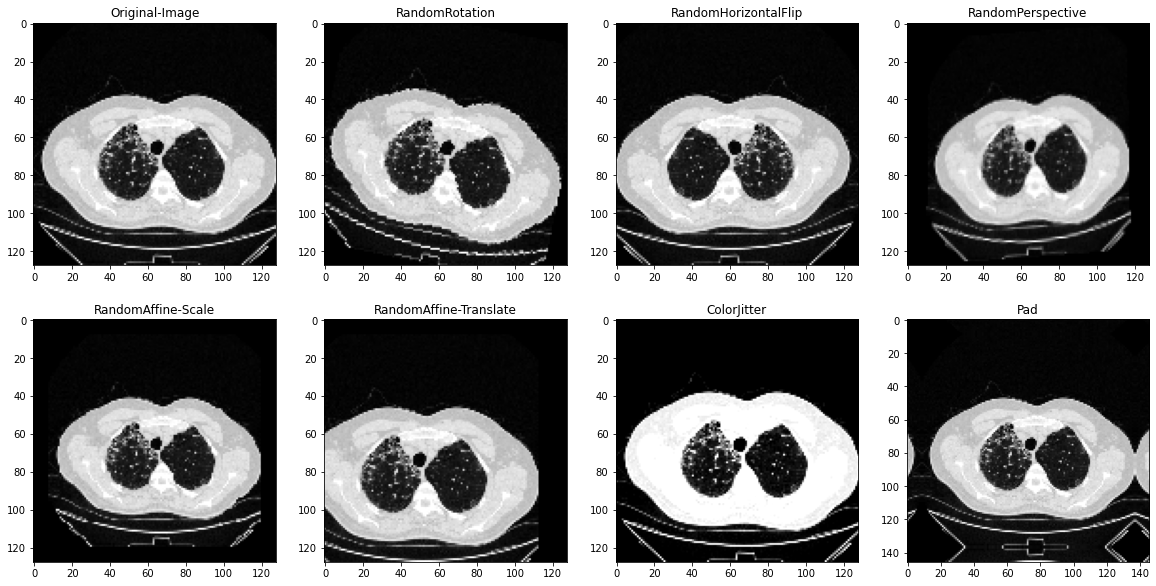

In [60]:
show_classic_aug(Lung_ima)

In [61]:
def save_classic_aug(image, path):
    try:
        image = image.convert('grayscale')
        image.save(path)
    except (ValueError, KeyError, OSError) as err:
        print(err)
        return None

In [62]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


In [63]:
img_rows = 128
img_cols = 128
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [64]:
def generator(img_shape, z_dim):
    
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(128*128*1, activation='tanh'))
    model.add(Reshape(img_shape))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

In [65]:
def discriminator(img_shape):
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

In [66]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [67]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    
    data_slice = 20
    X_train = X[0:100,:]
    #X_train = X[:data_slice,:]
    # Rescale -1 to 1
    #X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            sample_image(iteration)

In [68]:
def sample_image(iteration):


    # Sample random noise
    z = np.random.normal(0, 1, 
              (1, z_dim))

    # Generate images from random noise 
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    plt.imshow(gen_imgs[0, :,:,0]*255, cmap = 'gray')

In [69]:
import warnings; warnings.simplefilter('ignore')

1/1 [==============================] - 0s 14ms/step
0 [D loss: 64.172334, acc.: 42.19%] [G loss: 0.898650]
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


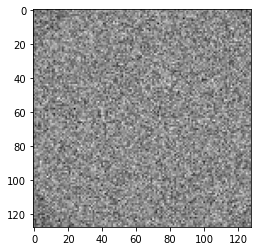

In [70]:
iterations = 250
batch_size = 32
sample_interval = 1000

# # Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

# #number of images: 10,798

In [71]:
output_path_single_class = "C:\\Users\\Mdsp\\Desktop\\Catalin project\\LungImageSegmentation-main\\output\\single_class\\"
output_path_multi_class = "C:\\Users\\Mdsp\\Desktop\\Catalin project\\LungImageSegmentation-main\\output\\multi_class\\"
preprocessing_output = "preprocessing\\"
evaluation_output = "evaluations\\"


In [77]:
import sklearn.metrics as metrics
def train_single_class(batch_size=8, start=0, end=30, n_classes=1, img_rows=128, img_cols=128):
    model = UNet2(img_rows=img_rows, img_cols=img_cols ,num_class=1, multiclass=False)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy']) 
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy', metrics.mean_squared_error, metrics.mean_absolute_error])
    model.summary()
    
    X, Y = getPolygonDatarange(hdf5File,start,end,aug=False, rows=img_rows, cols=img_cols)
    print(X.shape, Y.shape)
    Xnew = []
    Ynew = []
    for i in range(len(Y)):
        if cv2.countNonZero(Y[i]) != 0:
            
            Xnew.append(X[i])
            Ynew.append(Y[i])
    X = np.array(Xnew)
    Y = np.array(Ynew)
    print(X.shape, Y.shape)
    preprocessing_idxs = np.random.choice(X.shape[0], 9, replace=False)
    for i in range(preprocessing_idxs.shape[0]):
        cv2.imwrite(os.path.join(output_path_single_class+preprocessing_output, "Xpreprocessing_sample_stage_1_" + str(i) + ".jpeg"), X[preprocessing_idxs[i]])
        cv2.imwrite(os.path.join(output_path_single_class+preprocessing_output, "Ypreprocessing_sample_stage_1_" + str(i) + ".jpeg"), Y[preprocessing_idxs[i]])   

    trainX1, evalX, trainY1, evalY = train_test_split(X, Y, test_size=0.05, shuffle=True)
    trainX, valX, trainY, valY = train_test_split(trainX1, trainY1, test_size=0.2, shuffle=True)

    print("Train set size : ", len(trainX))
    print("Validation set size : ", len(valX))
    print("Total images : ", len(X))

    trainX, trainY, valX, valY = prepareData(trainX, trainY, valX, valY)

    csv_logger = CSVLogger('train'+str('')+'.log', append=True, separator=';')
    earlystopping = EarlyStopping(monitor='accuracy', verbose=1, min_delta=0.005, patience=3, mode='max')
    callbacks_list = [csv_logger, earlystopping]

    history = model.fit(trainX, trainY, epochs=6, batch_size=batch_size, verbose=1, validation_data=(valX, valY),callbacks=callbacks_list)
    
    model.save('model'+str('_single_class')+ str('UNet2_fixed') +'.hdf5')
    
    showResults(history)
    return model

In [78]:
def train(batch_size=32, start=0, end=30, n_classes=1, img_rows=128, img_cols=128):
    if n_classes == 1:
        return train_single_class(batch_size=batch_size, start=start, end=end, n_classes=1, img_rows=img_rows, img_cols=img_cols)
    else:
        return train_multiclass(batch_size=batch_size, start=start, end=end, n_classes=n_classes, img_rows=img_rows, img_cols=img_cols)

Single-Class Segmentation...
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                              

 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 16  0           ['conv2d_16[0][0]']              
          

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

BANNOURI



  3%|██▊                                                                                | 1/30 [00:00<00:24,  1.19it/s]

BENZID



  7%|█████▌                                                                             | 2/30 [00:05<01:19,  2.85s/it]

Benayoun



 10%|████████▎                                                                          | 3/30 [00:05<00:44,  1.63s/it]

Bouillon



 13%|███████████                                                                        | 4/30 [00:05<00:32,  1.24s/it]

Bousahba



 17%|█████████████▊                                                                     | 5/30 [00:06<00:21,  1.18it/s]

Bruneau



 20%|████████████████▌                                                                  | 6/30 [00:06<00:14,  1.61it/s]

CASSISA



 23%|███████████████████▎                                                               | 7/30 [00:06<00:11,  2.04it/s]

CHAUVEAU



 27%|██████████████████████▏                                                            | 8/30 [00:07<00:13,  1.61it/s]

Catillon



 33%|███████████████████████████▎                                                      | 10/30 [00:07<00:07,  2.55it/s]

Caussanel



 37%|██████████████████████████████                                                    | 11/30 [00:07<00:07,  2.64it/s]

Chevalier



 40%|████████████████████████████████▊                                                 | 12/30 [00:08<00:07,  2.27it/s]

Cohen



 43%|███████████████████████████████████▌                                              | 13/30 [00:08<00:06,  2.49it/s]

DIABY



 47%|██████████████████████████████████████▎                                           | 14/30 [00:09<00:07,  2.20it/s]

DIR



 50%|█████████████████████████████████████████                                         | 15/30 [00:09<00:06,  2.31it/s]

Debril



 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:10<00:03,  3.35it/s]

Desfrieches



 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:10<00:03,  3.32it/s]

Dioubate



 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:10<00:02,  3.78it/s]

Dourhbache



 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:10<00:02,  3.59it/s]

Erdogan



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:11<00:02,  3.69it/s]

FADLOUN



 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:11<00:02,  3.74it/s]

Farchaud



 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:11<00:01,  3.74it/s]

GARCIA



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:11<00:01,  3.67it/s]

GIRAUDEAU



 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:12<00:01,  3.61it/s]

GULLI



 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:13<00:02,  1.63it/s]

Gaiji



 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:13<00:01,  1.92it/s]

Gallier



 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:14<00:00,  2.04it/s]

Gerbaux



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:14<00:00,  2.43it/s]

Ghiles



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.02it/s]


(10798, 128, 128) (10798, 128, 128)
(10135, 128, 128) (10135, 128, 128)
Train set size :  7702
Validation set size :  1926
Total images :  10135
Epoch 1/6
241/241 [==============================] - 543s 2s/step - loss: 0.2820 - accuracy: 0.8568 - val_loss: 0.1559 - val_accuracy: 0.9234
Epoch 2/6
241/241 [==============================] - 534s 2s/step - loss: 0.1235 - accuracy: 0.9446 - val_loss: 0.1189 - val_accuracy: 0.9466
Epoch 3/6
241/241 [==============================] - 533s 2s/step - loss: 0.1016 - accuracy: 0.9556 - val_loss: 0.1008 - val_accuracy: 0.9554
Epoch 4/6
241/241 [==============================] - 535s 2s/step - loss: 0.0918 - accuracy: 0.9599 - val_loss: 0.0889 - val_accuracy: 0.9609
Epoch 5/6
241/241 [==============================] - 532s 2s/step - loss: 0.0841 - accuracy: 0.9634 - val_loss: 0.0922 - val_accuracy: 0.9593
Epoch 6/6
241/241 [==============================] - 534s 2s/step - loss: 0.0786 - accuracy: 0.9659 - val_loss: 0.0765 - val_accuracy: 0.9672


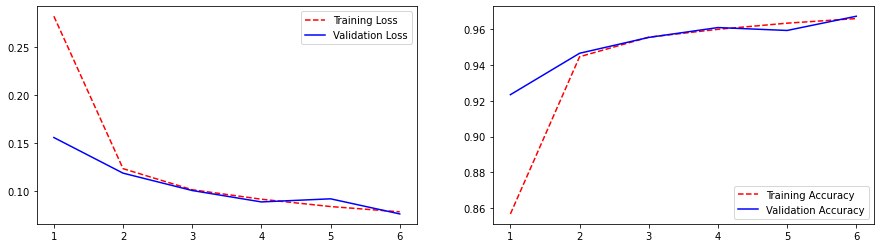

In [79]:
train()

In [ ]:
trainX1, evalX, trainY1, evalY = train_test_split(X, Y, test_size=0.05, shuffle=True)
trainX, valX, trainY, valY = train_test_split(trainX1, trainY1, test_size=0.2, shuffle=True)
print(evalX.shape)
score = model.evaluate(evalX, evalY, verbose=1)
    
print("Loss: {:.2f}".format(score[0]*100))
print("Accuracy: {:.2f}".format(score[1]*100))
csv_logger = CSVLogger('train'+str('')+'.log', append=True, separator=';')
earlystopping = EarlyStopping(monitor='accuracy', verbose=1, min_delta=0.005, patience=3, mode='max')
callbacks_list = [csv_logger, earlystopping]
evaluation_idxs = np.random.choice(valX.shape[0], 90, replace=False)
history = model.fit(trainX, trainY, epochs=6, batch_size=batch_size, verbose=1, validation_data=(valX, valY),callbacks=callbacks_list)
print(evaluation_idxs.shape[0])
print(os.path.join(output_path_single_class+evaluation_output, "Xevaluation_sample_stage_1_" + str(i) + ".jpeg"))
# for i in range(evaluation_idxs.shape[0]):
    
#     cv2.imwrite(os.path.join(output_path_single_class+evaluation_output, "Xevaluation_sample_stage_1_" + str(i) + ".jpeg"), valX[evaluation_idxs[i]]*255)
#     cv2.imwrite(os.path.join(output_path_single_class+evaluation_output, "Yevaluation_sample_stage_1_" + str(i) + ".jpeg"), valY[evaluation_idxs[i]])
#     cv2.imwrite(os.path.join(output_path_single_class+evaluation_output, "Preprocessing_sample_stage_1_" + str(i) + ".jpeg")
#                     , ((model.predict(np.expand_dims(valX[evaluation_idxs[i]], axis=0))*255).squeeze()))
showResults(history)

In [ ]:
model = load_model('model_single_classUNet2_fixed.hdf5')
# outputs=[model.output, model.get_layer('attention_vec').output]
# model_outputs = outputs[0]
# attention_outputs = outputs[1]

In [ ]:
outputs

In [ ]:
def postprocess_activations(attention_outputs):

  #using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(attention_outputs)
  output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image 
  output = cv2.resize(output, (128, 128))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

In [ ]:
Lung_ima = X[200]

In [ ]:
Lung_ima.shape

In [ ]:
plt.imshow(Lung_ima, cmap='gray')

In [ ]:
res = (model.predict(np.expand_dims(Lung_ima, axis = 0)))
print(np.expand_dims(Lung_ima, axis = 0).shape)
plt.imshow(res.squeeze(),cmap='gray')

In [ ]:
def preprocess(img):
  
  #expand the dimension
  return np.expand_dims(img, 0)

In [ ]:
def apply_heatmap(weights, img):
  #generate heat maps 
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
  return heatmap

In [ ]:
def plot_heatmaps(rng):
  level_maps = None
  
  #given a range of indices generate the heat maps 
  for i in rng:
    model = load_model('model_single_classAttentionNet.hdf5')
    outputs=[model.output, model.get_layer('attention_vec').output]
    model_outputs = outputs[0]
    attention_outputs = outputs[1]
    model = tf.keras.models.Model(inputs = model.inputs, outputs = attention_outputs)

    out = model.predict(np.expand_dims(Lung_ima, axis = 0))
    weights = postprocess_activations(out)
    heatmap = apply_heatmap(weights, cv2.cvtColor(Lung_ima,cv2.COLOR_GRAY2RGB))
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = np.concatenate([level_maps, heatmap], axis = 1)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  ax = plt.imshow(level_maps)

In [ ]:
plot_heatmaps(range(76, 81))
plot_heatmaps(range(3, 8))

In [ ]:
# def train_single_class(batch_size=8, start=0, end=30, n_classes=1, img_rows=128, img_cols=128):
#     model = UNet3(img_rows=img_rows, img_cols=img_cols ,num_class=1, multiclass=False)
#     model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy']) 
#     model.summary()
#     X, Y = getPolygonDatarange(hdf5File,start,end,aug=True, rows=img_rows, cols=img_cols)

    
#     preprocessing_idxs = np.random.choice(X.shape[0], 9, replace=False)
#     for i in range(preprocessing_idxs.shape[0]):
#         cv2.imwrite(os.path.join(output_path_single_class+preprocessing_output, "Xpreprocessing_sample_stage_1_" + str(i) + ".jpeg"), X[preprocessing_idxs[i]])
#         cv2.imwrite(os.path.join(output_path_single_class+preprocessing_output, "Ypreprocessing_sample_stage_1_" + str(i) + ".jpeg"), Y[preprocessing_idxs[i]])   

#     trainX1, evalX, trainY1, evalY = train_test_split(X, Y, test_size=0.05, shuffle=True)
#     trainX, valX, trainY, valY = train_test_split(trainX1, trainY1, test_size=0.2, shuffle=True)

#     print("Train set size : ", len(trainX))
#     print("Validation set size : ", len(valX))
#     print("Total images : ", len(X))

#     trainX, trainY, valX, valY = prepareData(trainX, trainY, valX, valY)

#     csv_logger = CSVLogger('train'+str('')+'.log', append=True, separator=';')
#     earlystopping = EarlyStopping(monitor='accuracy', verbose=1, min_delta=0.005, patience=3, mode='max')
#     callbacks_list = [csv_logger, earlystopping]

#     history = model.fit(trainX, trainY, epochs=10, batch_size=batch_size, verbose=1, validation_data=(valX, valY),callbacks=callbacks_list)

#     model.save('model'+str('_single_class')+ str('UNet3') +'.hdf5')
#     score = model.evaluate(evalX, evalY, verbose=1)

#     print("Loss: {:.2f}".format(score[0]*100))
#     print("Accuracy: {:.2f}".format(score[1]*100))

#     evaluation_idxs = np.random.choice(valX.shape[0], 90, replace=False)
#     for i in range(evaluation_idxs.shape[0]):
#         cv2.imwrite(os.path.join(output_path_single_class+evaluation_output, "Xevaluation_sample_stage_1_" + str(i) + ".jpeg"), valX[evaluation_idxs[i]]*255)
#         cv2.imwrite(os.path.join(output_path_single_class+evaluation_output, "Yevaluation_sample_stage_1_" + str(i) + ".jpeg"), valY[evaluation_idxs[i]]*255)
#         cv2.imwrite(os.path.join(output_path_single_class+evaluation_output, "Ppreprocessing_sample_stage_1_" + str(i) + ".jpeg")
#                     , (model.predict(np.expand_dims(valX[evaluation_idxs[i]], axis=0)))*255)
   

#     showResults(history)
    
#     return model

In [ ]:
# def train(batch_size=16, start=0, end=30, n_classes=1, img_rows=128, img_cols=128):
#     if n_classes == 1:
#         return train_single_class(batch_size=batch_size, start=start, end=end, n_classes=1, img_rows=img_rows, img_cols=img_cols)
#     else:
#         return train_multiclass(batch_size=batch_size, start=start, end=end, n_classes=n_classes, img_rows=img_rows, img_cols=img_cols)

In [ ]:
# train()